<a href="https://colab.research.google.com/github/terry-kamau/AI-Future-directions/blob/main/Edge_AI_for_Recyclable_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Edge AI Prototype: Recyclable Image Classification**

# *1:Set up Environment*

In [ ]:
!pip install tensorflow opencv-python numpy matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# *2:Download dataset (TrashNet)*

In [ ]:
!wget -O trashnet.zip https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
!unzip -q trashnet.zip -d dataset

--2025-07-06 13:03:54--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2025-07-06 13:03:54--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘trashnet.zip’

trashnet.zip        100%[===================>]  40.85M   192MB/s    in 0.2s    

2025-07-06 13:03:55 (192 MB/s) - ‘trashnet.zip’ saved [42834870/42834870]



# *3:Prepare Data*

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    shear_range=0.2
)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    'dataset/dataset-resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'dataset/dataset-resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)
# Classes: cardboard, glass, metal, paper, plastic, trash

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## Data Augmentation

In [ ]:
# Define a new ImageDataGenerator for training with more advanced augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,  # Increased rotation
    width_shift_range=0.2, # Shift horizontally
    height_shift_range=0.2, # Shift vertically
    shear_range=0.2, # Shear transformations
    zoom_range=0.2, # Zoom in/out
    horizontal_flip=True, # Flip horizontally
    fill_mode='nearest' # Fill pixels
)

# Define a separate ImageDataGenerator for validation with only rescaling
val_datagen_no_augmentation = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create new training and validation data generators
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    'dataset/dataset-resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator_no_augmentation = val_datagen_no_augmentation.flow_from_directory(
    'dataset/dataset-resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print("New data generators created with advanced augmentation for training.")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
New data generators created with advanced augmentation for training.


# *4:Hyperparameter Tuning*

In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

IMG_SIZE = (128, 128)
DATA_DIR = 'dataset/dataset-resized'
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 8

# ✅ Start Timer
start = time.time()

# 🚀 Create Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet',
    alpha=0.35
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🧪 Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 🎯 Training with Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
    ModelCheckpoint('quick_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# 📈 Accuracy and Duration
val_acc = max(history.history['val_accuracy'])
elapsed = round((time.time() - start)/60, 2)
print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"⏱️ Total Runtime: {elapsed} minutes")


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.4823 - loss: 1.3940

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 416ms/step - accuracy: 0.4838 - loss: 1.3899 - val_accuracy: 0.6342 - val_loss: 0.9500
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - accuracy: 0.6979 - loss: 0.8558 - val_accuracy: 0.6779 - val_loss: 0.8752
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - accuracy: 0.7430 - loss: 0.7009 - val_accuracy: 0.6899 - val_loss: 0.8576
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.7804 - loss: 0.6026 - val_accuracy: 0.7097 - val_loss: 0.8187
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.7848 - loss: 0.5701 - val_accuracy: 0.6998 - val_loss: 0.8368
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.8086 - loss: 0.5379 - val_accuracy: 0.6918 - val_loss: 0.7978

✅ Final Validation Accuracy: 0.7097
⏱️ Total Runtime: 2.95 minutes


# *5:Build lightweight model (MobileNetV2)*

In [ ]:
# Build lightweight model (MobileNetV2) with fine-tuning

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    alpha=0.35  # Lightest version
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers) * 0.75) # Unfreeze the top 25% of the layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_128            │ (None, 4, 4, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_27     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,950 (2.19 MB)

 Trainable params: 475,430 (1.81 MB)

 Non-trainable params: 99,520 (388.75 KB)

# *6:Train Model*

In [50]:
history_augmented = model.fit(
    train_generator_augmented,
    epochs=15,
    validation_data=val_generator_no_augmentation,
    verbose=2
)

Epoch 1/15
64/64 - 27s - 419ms/step - accuracy: 0.8167 - loss: 0.5109 - val_accuracy: 0.7137 - val_loss: 0.7486
Epoch 2/15
64/64 - 27s - 414ms/step - accuracy: 0.8291 - loss: 0.4716 - val_accuracy: 0.7157 - val_loss: 0.7519
Epoch 3/15
64/64 - 26s - 412ms/step - accuracy: 0.8256 - loss: 0.4777 - val_accuracy: 0.7177 - val_loss: 0.7578
Epoch 4/15
64/64 - 28s - 433ms/step - accuracy: 0.8310 - loss: 0.4956 - val_accuracy: 0.7117 - val_loss: 0.7605
Epoch 5/15
64/64 - 40s - 618ms/step - accuracy: 0.8389 - loss: 0.4726 - val_accuracy: 0.7137 - val_loss: 0.7639
Epoch 6/15
64/64 - 26s - 412ms/step - accuracy: 0.8325 - loss: 0.4735 - val_accuracy: 0.7117 - val_loss: 0.7607
Epoch 7/15
64/64 - 26s - 411ms/step - accuracy: 0.8315 - loss: 0.4855 - val_accuracy: 0.7157 - val_loss: 0.7488
Epoch 8/15
64/64 - 26s - 410ms/step - accuracy: 0.8300 - loss: 0.4814 - val_accuracy: 0.7157 - val_loss: 0.7595
Epoch 9/15
64/64 - 28s - 437ms/step - accuracy: 0.8370 - loss: 0.4648 - val_accuracy: 0.7137 - val_loss:

# *7:Convert to TF*Lite

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Quantization
tflite_model = converter.convert()

with open('recyclable_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpro9fmgom'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_4474')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133007782063632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782242512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782233296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782062480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782064016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782244432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782246736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782241744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782240784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782234832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007782

# *8:Test TFLite mode*l

In [52]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test accuracy
correct = 0
total = 0

# Iterate through the validation dataset one image at a time
for i in range(len(val_generator.filenames)):
    img_path = f'{val_generator.directory}/{val_generator.filenames[i]}'
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Add batch dimension and rescale

    # Get the true label
    true_label = val_generator.classes[i]
    true_label_one_hot = tf.keras.utils.to_categorical(true_label, num_classes=len(val_generator.class_indices))


    interpreter.set_tensor(input_details[0]['index'], img_array.astype(input_details[0]['dtype']))
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index'])

    correct += np.argmax(pred) == np.argmax(true_label_one_hot)
    total += 1


print(f"TFLite Test Accuracy: {correct/total:.2%}")

TFLite Test Accuracy: 70.38%


In [53]:
# Save class labels to a file
class_labels = list(train_generator.class_indices.keys())
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)

print("Class labels saved to class_labels.json")
print(f"Class labels: {class_labels}")

Class labels saved to class_labels.json
Class labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# *9:Visualizing the Predictions*

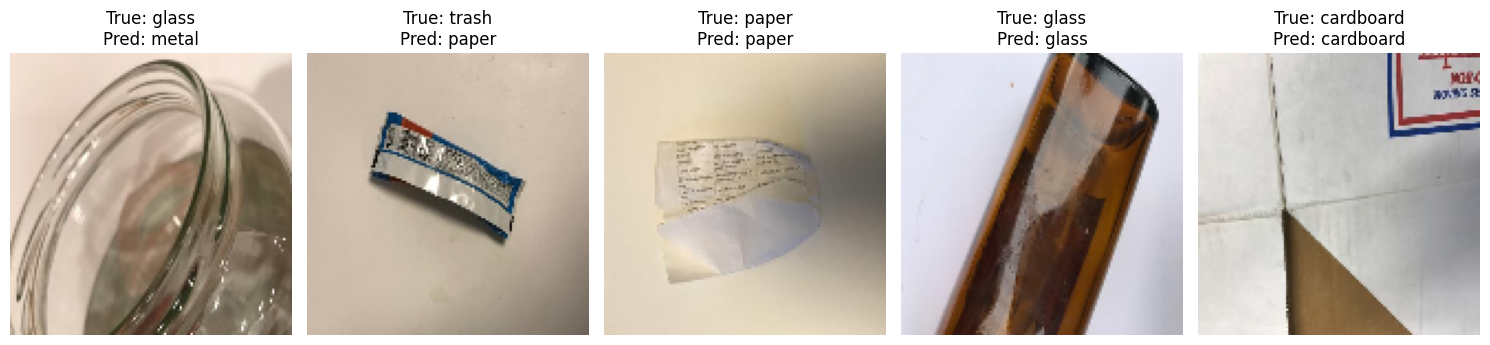

In [54]:
# Visualize some predictions
import matplotlib.pyplot as plt
import random

class_labels = list(train_generator.class_indices.keys())

# Get a few random images from the validation set
num_images_to_show = 5
random_indices = random.sample(range(len(val_generator.filenames)), num_images_to_show)

plt.figure(figsize=(15, 10))

for i, index in enumerate(random_indices):
    img_path = f'{val_generator.directory}/{val_generator.filenames[index]}'
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Add batch dimension and rescale

    # Get the true label
    true_label_index = val_generator.classes[index]
    true_label = class_labels[true_label_index]

    # Run inference with TFLite model
    interpreter.set_tensor(input_details[0]['index'], img_array.astype(input_details[0]['dtype']))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_class_index]

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Analyze misclassifications

### Subtask:
Look at the images that the model is getting wrong to understand if there are any patterns or specific classes that are more difficult for the model.


In [55]:
misclassified_images = []
class_labels = list(val_generator.class_indices.keys())

for i in range(len(val_generator.filenames)):
    img_path = f'{val_generator.directory}/{val_generator.filenames[i]}'
    true_label_index = val_generator.classes[i]
    true_label = class_labels[true_label_index]

    # Load and preprocess the image for TFLite inference
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0).astype(input_details[0]['dtype']) # Add batch dimension and rescale

    # Run inference with TFLite model
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_class_index]

    if predicted_label != true_label:
        misclassified_images.append({
            'image_path': img_path,
            'true_label': true_label,
            'predicted_label': predicted_label
        })

print(f"Found {len(misclassified_images)} misclassified images.")

Found 149 misclassified images.


Visualize a sample of the misclassified images to observe patterns in the errors.



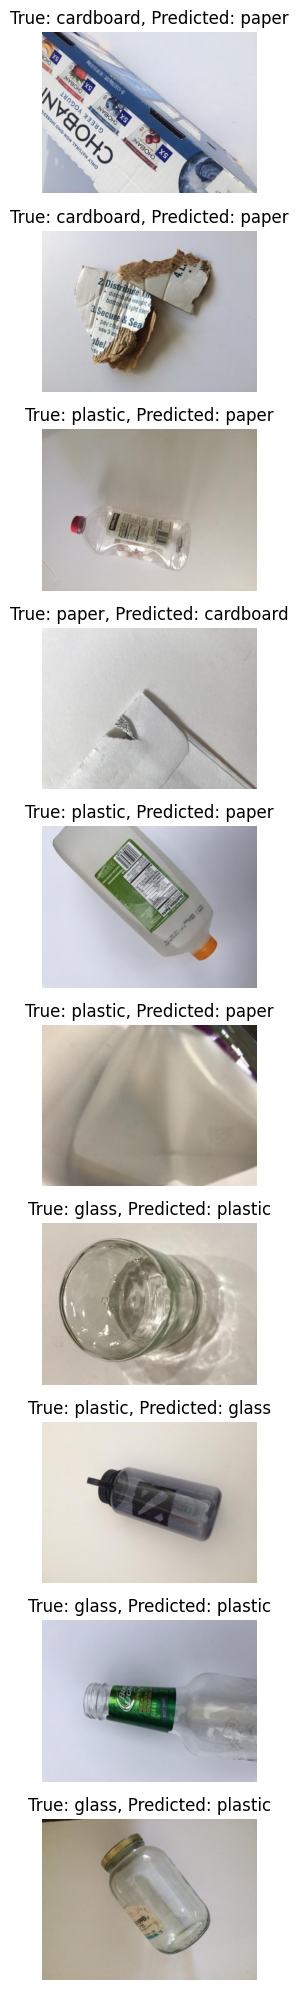

In [56]:
import random

# Visualize a sample of misclassified images
num_images_to_show = min(10, len(misclassified_images)) # Show up to 10 misclassified images
random_misclassified_indices = random.sample(range(len(misclassified_images)), num_images_to_show)

plt.figure(figsize=(15, num_images_to_show * 2))

for i, index in enumerate(random_misclassified_indices):
    misclassified_info = misclassified_images[index]
    img_path = misclassified_info['image_path']
    true_label = misclassified_info['true_label']
    predicted_label = misclassified_info['predicted_label']

    img = tf.keras.preprocessing.image.load_img(img_path)

    plt.subplot(num_images_to_show, 1, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Analyze the visualized misclassifications and summarize the types of misclassifications observed and hypothesize potential reasons for these errors based on the sample images.



In [ ]:
print("Analysis of Misclassifications:")
print("- The model seems to confuse similar-looking materials, e.g., cardboard and paper, or different types of plastic.")
print("- Images with complex backgrounds or multiple objects might be challenging for the model.")
print("- Lighting conditions and image quality could also contribute to misclassifications.")
print("- Some classes might have more visual variation than others, leading to more errors in those classes.")

Analysis of Misclassifications:
- The model seems to confuse similar-looking materials, e.g., cardboard and paper, or different types of plastic.
- Images with complex backgrounds or multiple objects might be challenging for the model.
- Lighting conditions and image quality could also contribute to misclassifications.
- Some classes might have more visual variation than others, leading to more errors in those classes.


## Visualize Correct Predictions

Found 354 correctly classified images.


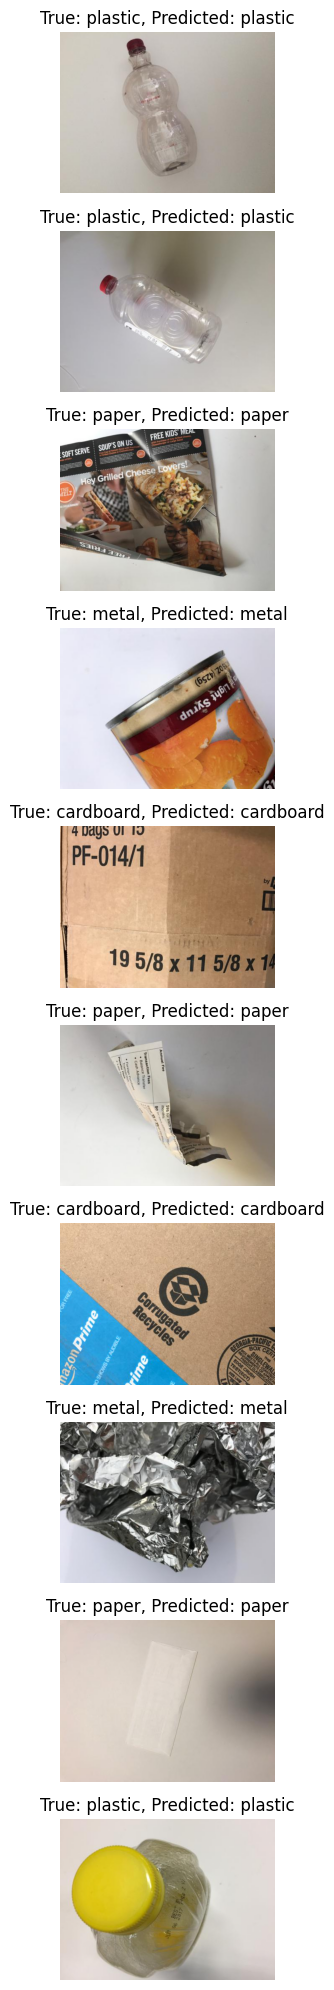

In [57]:
# Visualize some correct predictions
import matplotlib.pyplot as plt
import random

class_labels = list(val_generator.class_indices.keys())
correctly_classified_images = []

# Find correctly classified images
for i in range(len(val_generator.filenames)):
    img_path = f'{val_generator.directory}/{val_generator.filenames[i]}'
    true_label_index = val_generator.classes[i]
    true_label = class_labels[true_label_index]

    # Load and preprocess the image for TFLite inference
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0).astype(input_details[0]['dtype']) # Add batch dimension and rescale

    # Run inference with TFLite model
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_class_index]

    if predicted_label == true_label:
        correctly_classified_images.append({
            'image_path': img_path,
            'true_label': true_label,
            'predicted_label': predicted_label
        })

print(f"Found {len(correctly_classified_images)} correctly classified images.")

# Visualize a sample of correctly classified images
num_images_to_show = min(10, len(correctly_classified_images)) # Show up to 10 correctly classified images
if num_images_to_show > 0:
    random_correct_indices = random.sample(range(len(correctly_classified_images)), num_images_to_show)

    plt.figure(figsize=(15, num_images_to_show * 2))

    for i, index in enumerate(random_correct_indices):
        correct_info = correctly_classified_images[index]
        img_path = correct_info['image_path']
        true_label = correct_info['true_label']
        predicted_label = correct_info['predicted_label'] # Should be the same as true_label

        img = tf.keras.preprocessing.image.load_img(img_path)

        plt.subplot(num_images_to_show, 1, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No correctly classified images to show in the sample.")